# IMDB Sentiment Using Neural Networks
Collect the IMDB movie review datasets and use a deep learning model that will be trained and utilized to predict sentiment correctly

## Load Data

In [1]:
# import os
# os.environ["CUDA_VISIBLE_DEVICES"]="-1"
# import tensorflow as tf
# tf.config.experimental.set_visible_devices([], 'GPU')
import numpy as np
import pandas as pd

In [2]:
from keras.datasets import imdb

StartCharIndex = 1
OOVCharIndex = 2
WordIndexOffset = 3
UniqueWordMax = None
# UniqueWordMax = 5000 + WordIndexOffset - 1

(TrainX, TrainY), (TestX, TestY) = imdb.load_data(path="imdb.npz",
                                                  num_words = UniqueWordMax,
                                                  skip_top = 0,
                                                  maxlen = None,
                                                  seed = 13,
                                                  start_char = StartCharIndex,
                                                  oov_char = OOVCharIndex,
                                                  index_from = WordIndexOffset,
                                                 )

Using TensorFlow backend.


In [3]:
print(TrainX.shape)
print(TrainY.shape)

(25000,)
(25000,)


In [4]:
print(TestX.shape)
print(TestY.shape)

(25000,)
(25000,)


##### Merge datasets to get bigger training split

In [5]:
# TrainTestX = np.concatenate((TrainX, TestX), axis = 0)
# print(TrainTestX.shape)

In [6]:
# TrainTestY = np.concatenate((TrainY, TestY), axis = 0)
# print(TrainTestY.shape)

In [7]:
from sklearn.model_selection import train_test_split

TrainX, TestX, TrainY, TestY = train_test_split(np.concatenate((TrainX, TestX), axis = 0),
                                                np.concatenate((TrainY, TestY), axis = 0),
                                               test_size = 0.2,
                                               random_state = 13)

In [8]:
print(TrainX.shape)
print(TrainY.shape)

(40000,)
(40000,)


In [9]:
print(TestX.shape)
print(TestY.shape)

(10000,)
(10000,)


## Data Processing

In [10]:
import numpy as np
import pandas as pd

def GetArrayStats(ArrayData):
    resultsData = pd.DataFrame()
    resultsData = resultsData.append({
        "Stat": "Min",
        "Value": np.min(ArrayData),
    }, ignore_index = True)
    resultsData = resultsData.append({
        "Stat": "Max",
        "Value": np.max(ArrayData),
    }, ignore_index = True)
    resultsData = resultsData.append({
        "Stat": "Mean",
        "Value": np.mean(ArrayData),
    }, ignore_index = True)
    resultsData = resultsData.append({
        "Stat": "Median",
        "Value": np.median(ArrayData),
    }, ignore_index = True)
    resultsData = resultsData.append({
        "Stat": "Std Dev",
        "Value": np.std(ArrayData),
    }, ignore_index = True)
    with pd.option_context("display.max_rows", None, "display.max_colwidth", None):
        print(resultsData)
    return resultsData

In [11]:
# Sentiments, positive and negative
GetArrayStats(TrainY);
GetArrayStats(TestY);

      Stat     Value
0      Min  0.000000
1      Max  1.000000
2     Mean  0.499525
3   Median  0.000000
4  Std Dev  0.500000
      Stat     Value
0      Min  0.000000
1      Max  1.000000
2     Mean  0.501900
3   Median  1.000000
4  Std Dev  0.499996


In [12]:
print(np.max(np.hstack(TrainX)))
print(np.max(np.hstack(TestX)))

88586
88584


#### Reduce Training set parameters to words of significant number 

In [13]:
# Note: Some words are unique to Test set after the split due to low inherent word count
UniqueWordCounts = pd.Series(np.hstack(TrainX)).value_counts().drop([StartCharIndex, OOVCharIndex], axis = 0)
print(UniqueWordCounts)

4        533957
5        259659
6        258197
7        231256
8        214594
          ...  
68795         1
76991         1
52354         1
60550         1
72725         1
Length: 82468, dtype: int64


In [14]:
# Total count of words of potential interest
print(UniqueWordCounts.sum())

9355444


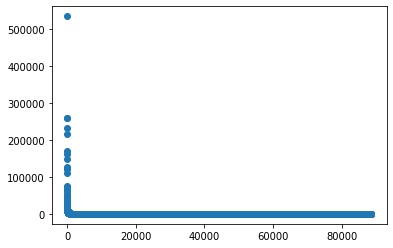

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.scatter(UniqueWordCounts.index, UniqueWordCounts)
plt.show()

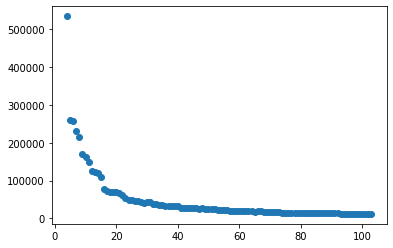

In [16]:
plt.scatter(UniqueWordCounts.index[:100], UniqueWordCounts[:100])
plt.show()

In [17]:
# Counts of word that occur more than 1% in the entire dataset
import pandas as pd
UniqueWordCounts.loc[UniqueWordCounts > (0.01 * UniqueWordCounts.sum())]

4     533957
5     259659
6     258197
7     231256
8     214594
9     169192
10    162103
11    149246
12    126088
13    123850
14    120591
15    109571
dtype: int64

In [18]:
UniqueWordMax = np.max(UniqueWordCounts.loc[UniqueWordCounts > (0.01 * UniqueWordCounts.sum())].index)
print(UniqueWordMax)

15


In [19]:
UniqueWordCounts.index.min()

4

In [20]:
TrainX_Reduced = [[word for word in row if (word in range(UniqueWordCounts.index.min(), UniqueWordMax + 1))] for row in TrainX]

In [21]:
pd.Series(np.hstack(TrainX_Reduced)).astype("int").value_counts()

4     533957
5     259659
6     258197
7     231256
8     214594
9     169192
10    162103
11    149246
12    126088
13    123850
14    120591
15    109571
dtype: int64

### Pad/Truncate review text strings to uniform length

#### Determine a row length cutoff

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline

In [23]:
print(np.max([len(row) for row in TestX]))

1854


In [24]:
TrainX_RowLengths = [len(row) for row in TrainX_Reduced]

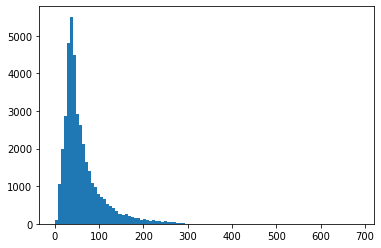

In [25]:
plt.close("all")
plt.hist(TrainX_RowLengths, bins = 100)
plt.show()

In [26]:
print(np.max(TrainX_RowLengths))

686


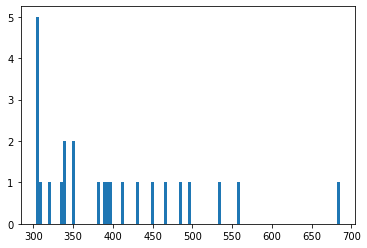

In [27]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.close("all")
plt.hist([len(row) for row in TrainX_Reduced if (len(row) > 300)], bins = 100)
plt.show()

In [28]:
len([len(row) for row in TrainX_Reduced if (len(row) > 300)])

25

In [29]:
len([len(row) for row in TrainX_Reduced if (len(row) > 300)]) / len(TrainX_Reduced)

0.000625

In [30]:
# ReviewTextLengthMax = int(np.median([len(row) - 1 for row in TrainTestX]) + 3 * np.std([len(row) - 1 for row in TrainTestX]))
# ReviewTextLengthMax = np.max(TrainX_RowLengths)
ReviewTextLengthMax = np.max([len(row) for row in TestX]) # Test dataset has extra words which increases input size
ReviewTextLengthMax

1854

#### Pad short rows and truncate longer rows

In [90]:
from keras.preprocessing import sequence
FillCharIndex = 0
TrainData = sequence.pad_sequences(TrainX_Reduced, maxlen = 500, value = FillCharIndex, padding = "post")
TrainTarget = TrainY
TestData = sequence.pad_sequences(TestX, maxlen = 500, value = FillCharIndex, padding = "post")
TestTarget = TestY

In [91]:
print(TrainData.shape)
print(TrainData)
print("")
print(TrainTarget.shape)
print(TrainTarget)

(40000, 500)
[[14 15  4 ...  0  0  0]
 [ 5 14  6 ...  0  0  0]
 [14  9  7 ...  0  0  0]
 ...
 [12  4  7 ...  0  0  0]
 [14  8 13 ...  0  0  0]
 [13  6 13 ...  0  0  0]]

(40000,)
[1 1 1 ... 1 0 1]


In [92]:
print(TestData.shape)
print(TestData)
print("")
print(TestTarget.shape)
print(TestTarget)

(10000, 500)
[[   1 4922 9519 ...    0    0    0]
 [   1   14    9 ...    0    0    0]
 [   1   50   26 ...    0    0    0]
 ...
 [   1   92   79 ...    0    0    0]
 [   1  137  149 ...    0    0    0]
 [   1   50   16 ...    0    0    0]]

(10000,)
[0 1 0 ... 0 1 1]


## Setup Neural Network

In [93]:
InputShape = (1, TestData.shape[1])
InputSize = TestData.shape[1]
print(InputShape)
print(InputSize)
InputUnitsCount = 32
# InputUnitsCount = UniqueWordMax
BatchSize = 256
KernelSize = 4
PoolSize = 2
Filters = 64
HiddenUnitsCount = 128
DropoutRate = 0.2
LabelCount = 1

(1, 500)
500


## Run network models and determine accuracy

In [45]:
import keras
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix

### Simple RNN

In [94]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Embedding
from keras.layers import SimpleRNN
from keras.optimizers import SGD#, RMSprop, Adam


def CreateRNN():
    keras.backend.clear_session()
    model = Sequential()
    # Input Layer
    model.add(Embedding(UniqueWordMax, InputUnitsCount, input_length = InputSize))
    model.add(SimpleRNN(units = HiddenUnitsCount, dropout = DropoutRate, input_shape = InputShape))
    # Output Layer
    model.add(Dense(LabelCount))
    model.add(Activation("sigmoid"))
    
    model.compile(loss = "binary_crossentropy",
                 optimizer = SGD(),
                 metrics = ["accuracy"])
    return model

In [95]:
model = CreateRNN()
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 32)           480       
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 128)               20608     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
_________________________________________________________________
activation_1 (Activation)    (None, 1)                 0         
Total params: 21,217
Trainable params: 21,217
Non-trainable params: 0
_________________________________________________________________


In [96]:
model.fit(TrainData, TrainTarget, epochs = 15, batch_size = BatchSize, verbose = 2)

C:\ProgramData\Anaconda3\envs\DataScience\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/15
 - 29s - loss: 0.6936 - accuracy: 0.4985
Epoch 2/15
 - 29s - loss: 0.6935 - accuracy: 0.4960
Epoch 3/15
 - 29s - loss: 0.6932 - accuracy: 0.5037
Epoch 4/15
 - 29s - loss: 0.6932 - accuracy: 0.5070
Epoch 5/15
 - 29s - loss: 0.6931 - accuracy: 0.5044
Epoch 6/15
 - 29s - loss: 0.6932 - accuracy: 0.5043
Epoch 7/15
 - 29s - loss: 0.6931 - accuracy: 0.5051
Epoch 8/15
 - 29s - loss: 0.6931 - accuracy: 0.5038
Epoch 9/15
 - 29s - loss: 0.6932 - accuracy: 0.5031
Epoch 10/15
 - 29s - loss: 0.6932 - accuracy: 0.5028
Epoch 11/15
 - 29s - loss: 0.6932 - accuracy: 0.5003
Epoch 12/15
 - 29s - loss: 0.6933 - accuracy: 0.5010
Epoch 13/15
 - 28s - loss: 0.6932 - accuracy: 0.5032
Epoch 14/15
 - 28s - loss: 0.6932 - accuracy: 0.5021
Epoch 15/15
 - 29s - loss: 0.6934 - accuracy: 0.5006


In [97]:
TestPredictions = model.predict(TestData)

In [98]:
TestPredictions

array([[0.5012448 ],
       [0.503517  ],
       [0.4899367 ],
       ...,
       [0.5030724 ],
       [0.49427074],
       [0.50504714]], dtype=float32)

In [99]:
GetArrayStats([TestTarget]);
GetArrayStats([TestPredictions]);

      Stat     Value
0      Min  0.000000
1      Max  1.000000
2     Mean  0.501900
3   Median  1.000000
4  Std Dev  0.499996
      Stat     Value
0      Min  0.403597
1      Max  0.588276
2     Mean  0.497415
3   Median  0.497367
4  Std Dev  0.010218


In [100]:
TestTarget[:20]

array([0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0],
      dtype=int64)

In [101]:
(TestPredictions.reshape(-1, ) >= 0.5).astype(int)[:20]

array([1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0])

In [102]:
accuracy_score(TestTarget, (TestPredictions >= 0.5).astype(int))

0.5039

### Simple LSTM

In [103]:
InputShape = (1, TrainData.shape[1])
InputSize = TrainData.shape[1]
print(InputShape)
print(InputSize)
BatchSize = 128
KernelSize = 4
PoolSize = 2
Filters = 64
HiddenUnitsCount = 256
DropoutRate = 0.2
LabelCount = 1

(1, 500)
500


In [104]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Embedding
from keras.layers import LSTM
#from keras.layers import Conv2D, MaxPool2D, Flatten
from keras.layers import Conv1D, MaxPool1D, Flatten
from keras.optimizers import SGD, RMSprop, Adam
import gc

def CreateLSTM():
    keras.backend.clear_session()
    gc.collect()
    
    model = Sequential()
    # Input Layer
    model.add(Embedding(UniqueWordMax, 32, input_length = InputSize))
#     model.add(LSTM(units = HiddenUnitsCount, dropout = DropoutRate, input_shape = InputShape, return_sequences = True))
#     model.add(Activation("softmax"))
    model.add(LSTM(units = HiddenUnitsCount, dropout = DropoutRate, input_shape = InputShape))
    model.add(Activation("softmax"))
#     model.add(LSTM(100))
#     model.add(Dropout(DropoutRate))
#     model.add(Activation("relu"))
    # Hidden Layer
#     model.add(Dense(800))
#     model.add(LSTM(10))
#     model.add(Dropout(DropoutRate))
#     model.add(Activation("relu"))
    # Output Layer
    model.add(Dense(LabelCount))
    model.add(Activation("sigmoid"))
    
    model.compile(loss = "binary_crossentropy",
                 optimizer = Adam(),
                 metrics = ["accuracy"])
    return model

In [105]:
model = CreateLSTM()
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 32)           480       
_________________________________________________________________
lstm_1 (LSTM)                (None, 256)               295936    
_________________________________________________________________
activation_1 (Activation)    (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
_________________________________________________________________
activation_2 (Activation)    (None, 1)                 0         
Total params: 296,673
Trainable params: 296,673
Non-trainable params: 0
_________________________________________________________________


In [106]:
model.fit(TrainData, TrainTarget, epochs = 15, batch_size = BatchSize, verbose = 2)

C:\ProgramData\Anaconda3\envs\DataScience\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/15
 - 92s - loss: 0.6932 - accuracy: 0.4986
Epoch 2/15
 - 91s - loss: 0.6932 - accuracy: 0.4968
Epoch 3/15
 - 91s - loss: 0.6932 - accuracy: 0.4964
Epoch 4/15
 - 91s - loss: 0.6932 - accuracy: 0.4971
Epoch 5/15
 - 91s - loss: 0.6932 - accuracy: 0.4952
Epoch 6/15
 - 91s - loss: 0.6932 - accuracy: 0.4950
Epoch 7/15
 - 91s - loss: 0.6932 - accuracy: 0.5004
Epoch 8/15
 - 92s - loss: 0.6932 - accuracy: 0.4963
Epoch 9/15
 - 91s - loss: 0.6932 - accuracy: 0.4994
Epoch 10/15
 - 92s - loss: 0.6932 - accuracy: 0.4982
Epoch 11/15
 - 92s - loss: 0.6932 - accuracy: 0.4986
Epoch 12/15
 - 92s - loss: 0.6932 - accuracy: 0.4983
Epoch 13/15
 - 91s - loss: 0.6932 - accuracy: 0.4983
Epoch 14/15
 - 91s - loss: 0.6932 - accuracy: 0.4999
Epoch 15/15
 - 91s - loss: 0.6932 - accuracy: 0.5034


In [114]:
TestPredictions = model.predict(TestData)

In [115]:
TestPredictions

array([[0.4952852],
       [0.4952852],
       [0.4952852],
       ...,
       [0.4952852],
       [0.4952852],
       [0.4952852]], dtype=float32)

In [116]:
GetArrayStats([TestTarget]);
GetArrayStats([TestPredictions]);

      Stat     Value
0      Min  0.000000
1      Max  1.000000
2     Mean  0.501900
3   Median  1.000000
4  Std Dev  0.499996
      Stat         Value
0      Min  4.952769e-01
1      Max  4.952954e-01
2     Mean  4.952852e-01
3   Median  4.952852e-01
4  Std Dev  4.708417e-07


In [117]:
(TestPredictions.reshape(-1, ) >= 0.5).astype(int)[:20]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [118]:
TestTarget[:20]

array([0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0],
      dtype=int64)

In [119]:
accuracy_score(TestTarget, (TestPredictions >= 0.5).astype(int))

0.4981

## Simple Multi Layer Perceptron

In [120]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Embedding, Flatten
from keras.optimizers import SGD, Adam

# InputShape = (1, TrainX.shape[1])
# InputSize = TrainX.shape[1]
# print("InputShape: " , InputShape)
# print("InputSize: ", InputSize)
# BatchSize = 128
# HiddenUnitsCount = 128
# KernelSize = 4
# DropoutRate = 0.2
# LabelCount = 1

def CreateMLP():
    keras.backend.clear_session()
    model = Sequential()
    
    # Input layer
    model.add(Dense(InputUnitsCount, input_dim = InputSize))
#     model.add(Embedding(UniqueWordMax, 32, input_length = InputSize))
#     model.add(Embedding(InputUnitsCount, 32, input_length = InputSize))
#     model.add(Flatten())
#     model.add(Dense(100))
    model.add(Activation("relu"))
    # Hidden Layer 1
    model.add(Dense(100))
    model.add(Activation("relu"))
    
    # Output layer
    model.add(Dense(LabelCount, activation = "sigmoid"))
    
    model.compile(
        loss = "binary_crossentropy",
        optimizer = Adam(),
        metrics = ["accuracy"]
    )
    
    return model

def CreateMLPWithEmbedding():
    keras.backend.clear_session()
    model = Sequential()
    
    # Input layer
    model.add(Embedding(input_dim = UniqueWordMax, output_dim = InputUnitsCount, input_length = InputSize))
#     model.add(Embedding(input_dim = InputSize, output_dim = KernelSize, input_length = InputSize))
#     model.add(Embedding(input_dim = InputUnitsCount, output_dim = KernelSize, input_length = InputSize))
    model.add(Flatten())
    model.add(Dense(InputUnitsCount))
#     model.add(Dense(InputSize))
#    model.add(Dropout(DropoutRate))
    model.add(Activation("relu"))
    # Hidden Layer 1
    model.add(Dense(InputUnitsCount))
#    model.add(Dropout(DropoutRate))
    model.add(Activation("relu"))
    
    # Output layer
    model.add(Dense(LabelCount, activation = "sigmoid"))
    
    model.compile(
        loss = "binary_crossentropy",
        optimizer = Adam(),
        metrics = ["accuracy"]
    )
    
    return model

In [121]:
model = CreateMLPWithEmbedding()
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 32)           480       
_________________________________________________________________
flatten_1 (Flatten)          (None, 16000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                512032    
_________________________________________________________________
activation_1 (Activation)    (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
activation_2 (Activation)    (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

In [122]:
model.fit(TrainData, TrainTarget, epochs = 15, batch_size = BatchSize, verbose = 2)

C:\ProgramData\Anaconda3\envs\DataScience\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/15
 - 1s - loss: 0.6829 - accuracy: 0.5520
Epoch 2/15
 - 1s - loss: 0.6624 - accuracy: 0.6021
Epoch 3/15
 - 1s - loss: 0.6525 - accuracy: 0.6126
Epoch 4/15
 - 1s - loss: 0.6365 - accuracy: 0.6276
Epoch 5/15
 - 1s - loss: 0.6073 - accuracy: 0.6523
Epoch 6/15
 - 1s - loss: 0.5636 - accuracy: 0.6868
Epoch 7/15
 - 1s - loss: 0.5126 - accuracy: 0.7232
Epoch 8/15
 - 1s - loss: 0.4656 - accuracy: 0.7552
Epoch 9/15
 - 1s - loss: 0.4225 - accuracy: 0.7828
Epoch 10/15
 - 1s - loss: 0.3866 - accuracy: 0.8043
Epoch 11/15
 - 1s - loss: 0.3578 - accuracy: 0.8223
Epoch 12/15
 - 1s - loss: 0.3306 - accuracy: 0.8393
Epoch 13/15
 - 1s - loss: 0.3125 - accuracy: 0.8489
Epoch 14/15
 - 1s - loss: 0.2949 - accuracy: 0.8593
Epoch 15/15
 - 1s - loss: 0.2828 - accuracy: 0.8649


In [123]:
TestPredictions = model.predict(TestData)

In [124]:
TestPredictions

array([[4.6406808e-01],
       [9.9909389e-01],
       [9.9997234e-01],
       ...,
       [9.2568254e-04],
       [9.7834480e-01],
       [3.8666424e-01]], dtype=float32)

In [125]:
GetArrayStats([TestTarget]);
GetArrayStats([TestPredictions]);

      Stat     Value
0      Min  0.000000
1      Max  1.000000
2     Mean  0.501900
3   Median  1.000000
4  Std Dev  0.499996
      Stat         Value
0      Min  5.805830e-28
1      Max  1.000000e+00
2     Mean  4.478442e-01
3   Median  3.329078e-01
4  Std Dev  4.222013e-01


In [126]:
(TestPredictions.reshape(-1, ) >= 0.5).astype(int)[:20]

array([0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1])

In [127]:
TestTarget[:20]

array([0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0],
      dtype=int64)

In [128]:
accuracy_score(TestTarget, (TestPredictions >= 0.5).astype(int))

0.532